In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGION_CODES = ['AS', 'GU', 'PR', 'VI', 'MP']

%config InlineBackend.figure_format = 'retina'

In [ ]:
df=pd.read_excel('covid_data.xlsx',index_col='date')
df=df.drop(['import','case'],axis=1)

In [ ]:
# Column vector of k
k = np.arange(0, 564)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(564, 4)


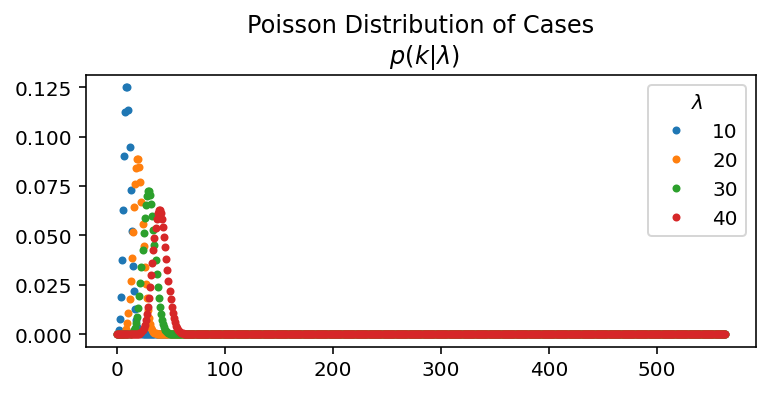

In [ ]:
fig, ax = plt.subplots(figsize=(6,2.5))

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

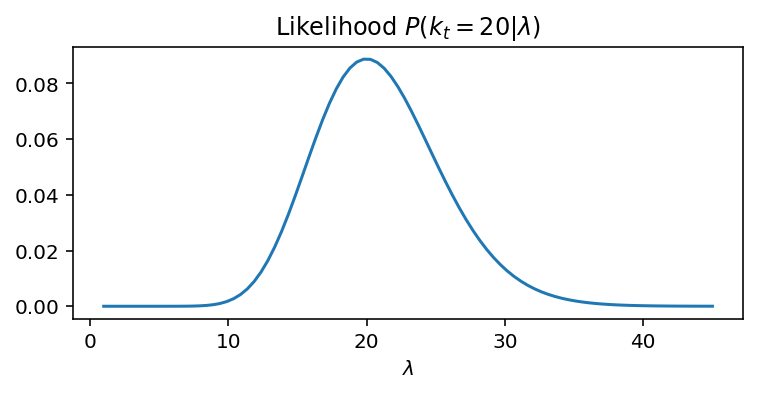

In [ ]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$', figsize=(6,2.5));

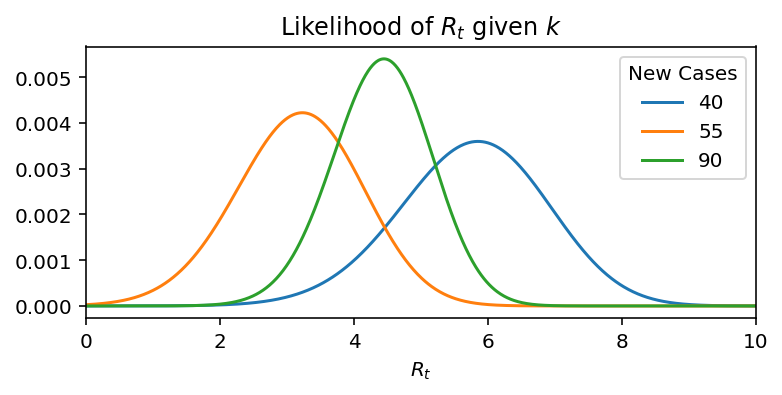

In [ ]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10),
    figsize=(6,2.5)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

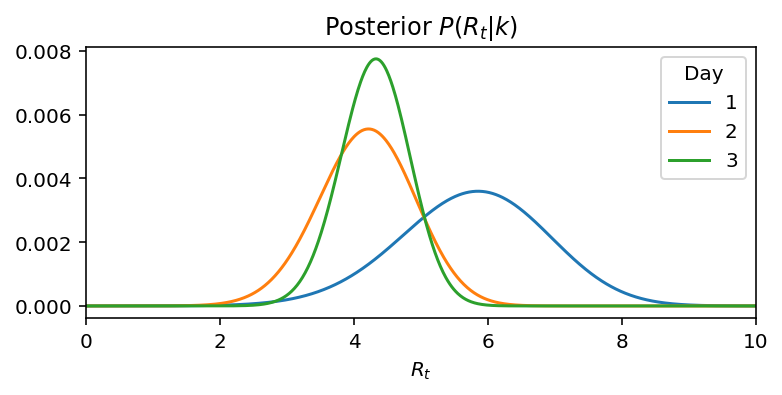

In [ ]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10),
    figsize=(6,2.5)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

In [ ]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

In [ ]:
def highest_density_interval(pmf, p=.95, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors, debug=True)
hdi.tail()

,Low_95,High_95
Day,,
1,3.54,7.90
2,2.70,5.53
3,3.28,5.30


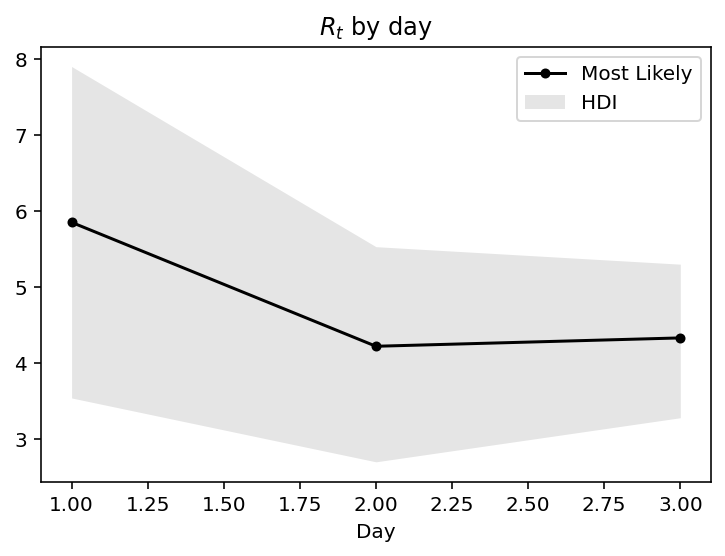

In [ ]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_95'],
                hdi['High_95'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

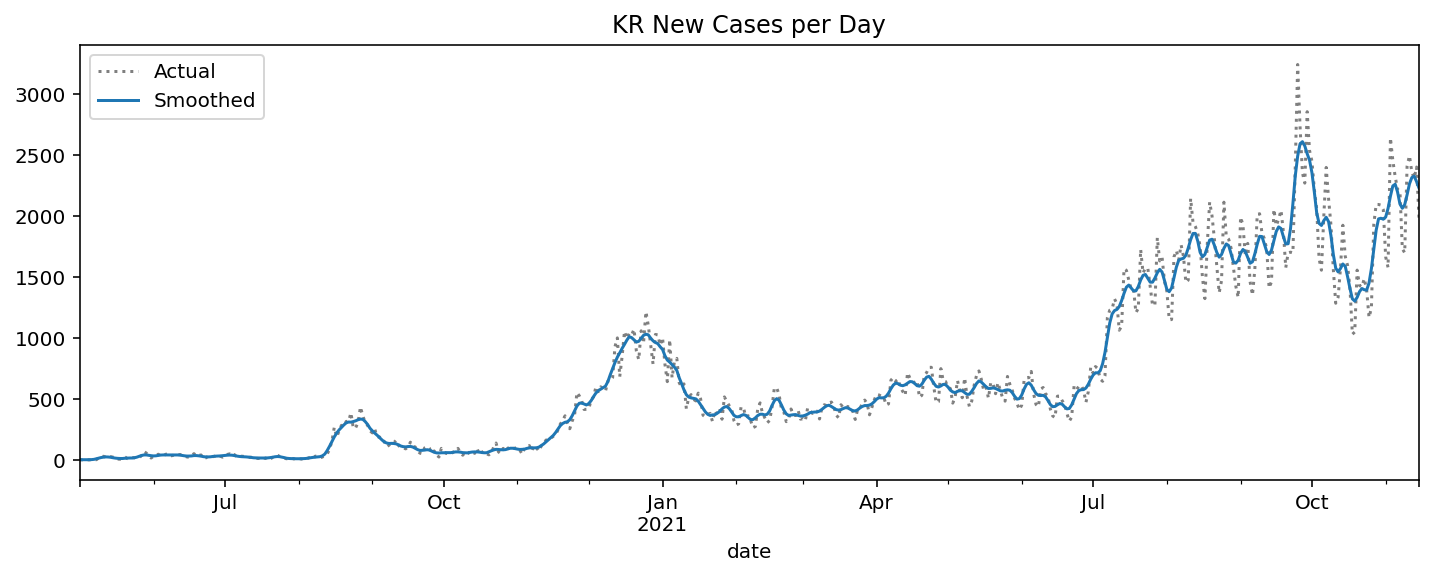

In [ ]:
state_name = 'KR'

def prepare_cases(cases, cutoff=20):
    new_cases = cases
    original=new_cases

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    # idx_start = np.searchsorted(smoothed, cutoff)
    
    # smoothed = smoothed.iloc[idx_start:]
    # original = new_cases.loc[smoothed.index]
    
    return original, smoothed

#cases = df.xs(state_name).rename(f"{state_name} cases")
cases = df['local']

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
                c='k',
                linestyle=':',
                alpha=.5,
                label='Actual',
                legend=True,
              figsize=(12, 4))

ax = smoothed.plot(label='Smoothed',
                    legend=True)
ax.get_figure().set_facecolor('w')

In [ ]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

In [ ]:
log_likelihood

-2404.15008309847

In [ ]:
posteriors

date,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,...,2021-11-06,2021-11-07,2021-11-08,2021-11-09,2021-11-10,2021-11-11,2021-11-12,2021-11-13,2021-11-14,2021-11-15
0.00,0.000833,0.000887,0.001010,0.001111,1.194370e-03,8.451463e-04,4.124728e-04,4.277561e-05,1.000293e-05,4.197699e-06,...,2.703694e-11,2.279169e-08,2.021597e-10,1.054649e-14,1.569585e-19,8.874927e-22,1.215014e-19,1.732118e-16,1.748935e-12,3.785415e-11
0.01,0.000833,0.000911,0.001040,0.001145,1.231463e-03,8.728059e-04,4.269372e-04,4.452887e-05,1.045084e-05,4.401159e-06,...,4.337769e-11,3.341724e-08,3.124574e-10,1.803685e-14,2.972147e-19,1.769481e-21,2.352829e-19,3.162487e-16,2.910905e-12,6.060278e-11
0.02,0.000833,0.000934,0.001070,0.001179,1.268422e-03,9.004613e-04,4.414692e-04,4.630895e-05,1.090885e-05,4.610560e-06,...,6.922980e-11,4.874551e-08,4.805503e-10,3.069687e-14,5.600301e-19,3.510083e-21,4.532275e-19,5.743198e-16,4.818887e-12,9.651004e-11
0.03,0.000833,0.000957,0.001100,0.001213,1.305184e-03,9.280689e-04,4.560483e-04,4.811413e-05,1.137672e-05,4.825907e-06,...,1.099095e-10,7.074019e-08,7.354214e-10,5.198829e-14,1.050040e-18,6.927505e-21,8.684732e-19,1.037409e-15,7.934640e-12,1.528800e-10
0.04,0.000833,0.000980,0.001129,0.001246,1.341688e-03,9.555853e-04,4.706540e-04,4.994264e-05,1.185424e-05,5.047204e-06,...,1.735761e-10,1.021323e-07,1.119904e-09,8.761791e-14,1.959075e-18,1.360260e-20,1.655420e-18,1.863865e-15,1.299472e-11,2.408934e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11.96,0.000833,0.000107,0.000015,0.000002,2.920652e-07,1.581032e-07,3.535874e-08,3.633052e-09,1.527202e-14,5.771255e-24,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
11.97,0.000833,0.000104,0.000014,0.000002,2.812948e-07,1.522559e-07,3.388851e-08,3.449003e-09,1.401734e-14,5.013715e-24,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
11.98,0.000833,0.000101,0.000014,0.000002,2.706864e-07,1.465042e-07,3.245327e-08,3.271820e-09,1.285740e-14,4.354274e-24,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
11.99,0.000833,0.000098,0.000013,0.000002,2.602475e-07,1.408512e-07,3.105320e-08,3.101346e-09,1.178553e-14,3.780360e-24,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


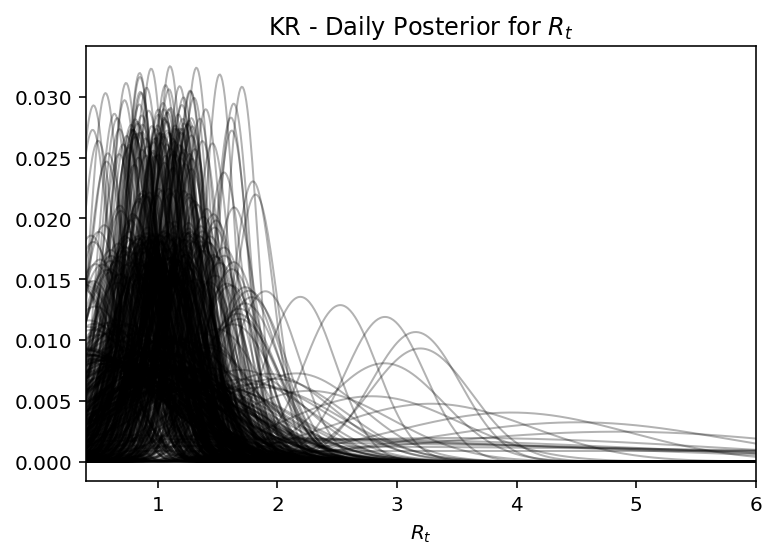

In [ ]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

In [ ]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.95)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_95,High_95
date,,,
2021-11-11,1.27,0.98,1.50
2021-11-12,1.18,0.91,1.42
2021-11-13,1.06,0.79,1.30
2021-11-14,0.91,0.64,1.15
2021-11-15,0.85,0.57,1.09


In [ ]:
result

,ML,Low_95,High_95
date,,,
2020-05-01,0.00,0.00,11.41
2020-05-02,0.40,0.00,9.90
2020-05-03,0.46,0.00,8.22
2020-05-04,0.51,0.00,7.14
2020-05-05,0.55,0.00,6.44
...,...,...,...
2021-11-11,1.27,0.98,1.50
2021-11-12,1.18,0.91,1.42
2021-11-13,1.06,0.79,1.30


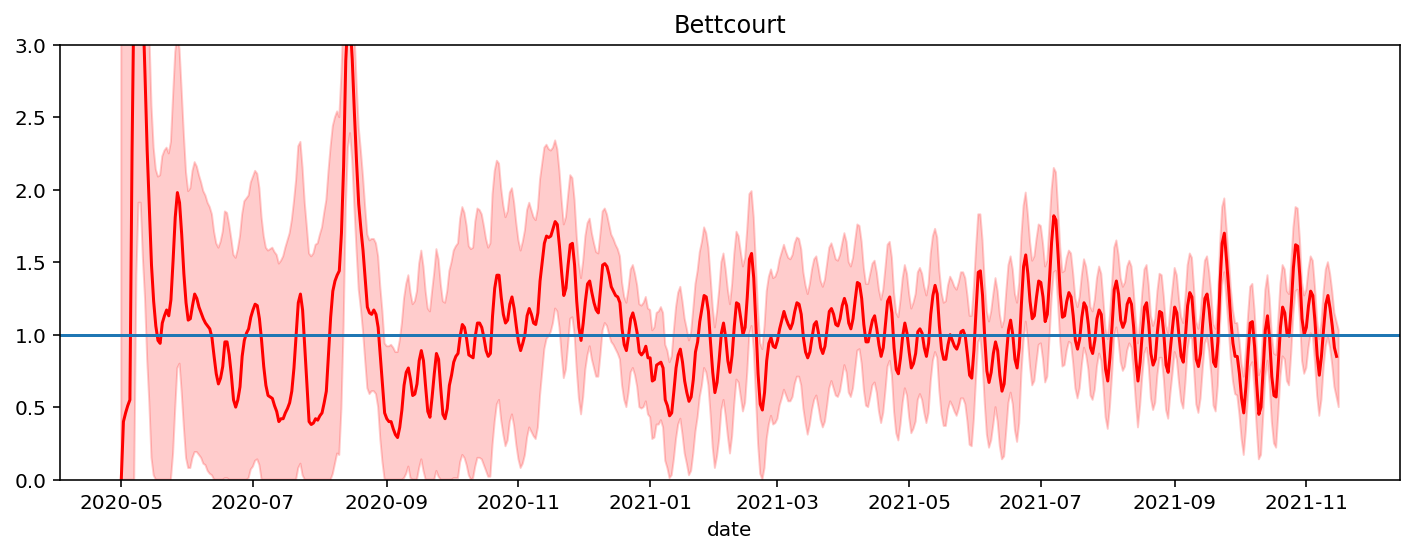

In [ ]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values,color='red')
    #ax.scatter(index,
    #           values,
    #           )
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_95'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_95'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-05-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='r',
                    alpha=.2,
                    )
    ax.axhline(y=1)
    ax.set_ylim([0,3])
    ax.set_title('Bettcourt')
    ax.set_xlabel('date')
    #ax.axhline(1.0, c='r', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting

    
fig, ax = plt.subplots(1,1, figsize=(12, 4))

plot_rt(result, ax, state_name)
#ax.set_title(f'Real-time $R_t$ for {state_name}')


In [ ]:
def Cori(i): # Cori update version
  a=df['local'].values[i] # I_t
  b=0 # b 초기화
  for k in range(1,i):
    b+=df.loc[i-k,'local']*df.loc[k,'W'] # I_t-s * Ws 
  if(b>0):
    r=a/b 
  else:
    r=0 
  return r

In [ ]:
for i in range(1,len(df.index)):
  df.loc[i,'Cori']=Cori(i)

In [ ]:
#def Bett(i): # Bett first version
#  a=df['local'].values[i+1] # I_t+1
#  b=df['local'].values[i] # I_t
#  r=0.5*np.log(a/b)+1
#  return r

In [ ]:
g1=len(df)/df['case'].sum()
g1

0.0014584911856964425

In [ ]:
g2=np.mean(df.loc[:,"W"])
g2

0.004784688995215311

In [ ]:
# g가 평균 발생 시간이여서 하루/감염자수 이렇게 설정
g3=1/df['case']
g3=g3.replace([np.inf,-np.inf],np.nan).dropna()
g3=g3.mean()

In [ ]:
def Bett_g1(i): # Bett update version
  a=df['local'].values[i+1] # I_t+1
  b=df['local'].values[i] # I_t
  r=g1*np.log(a/b)+1 
  return r

In [ ]:
for i in range(7,len(df.index)-1):
  df.loc[i,'Bett_g1']=Bett_g1(i)

In [ ]:
def Bett_g2(i): # Bett update version
  a=df['local'].values[i+1] # I_t+1
  b=df['local'].values[i] # I_t
  r=g2*np.log(a/b)+1 
  return r

In [ ]:
for i in range(7,len(df.index)-1):
  df.loc[i,'Bett_g2']=Bett_g2(i)

In [ ]:
def Bett_g3(i): # Bett update version
  a=df['case'].values[i+1] # I_t+1
  b=df['case'].values[i] # I_t
  r=g3*np.log(a/b)+1 
  return r

In [ ]:
for i in range(7,len(df.index)-1):
  df.loc[i,'Bett_g3']=Bett_g3(i)

In [ ]:
from datetime import datetime
def Wallinga(m):
  P=[]
  j=df.loc[m,'id'] # case j
  i=df.loc[m,'선행확진id'] # case i
  i=i.replace('\n',',')
  for tok in i.split(','): # case i가 여러개인 경우 존재
    tok = re.sub(r'[^0-9]', '', tok) # 선행 id만 추출
    if tok != '':
      if int(tok) in check: # 선행 id(i)가 주어진 데이터에 존재하는 경우
        total=0
        t_j=id_date[int(j)] # case j가 감염된 시간
        t_i=id_date[int(tok)]# case i가 감염된 시간
        t_j=datetime.strptime(t_j, '%Y-%m-%d')
        t_i=datetime.strptime(t_i, '%Y-%m-%d')
        for k in df.index: # Pij의 분모 구하기
          if i != k:
            t_k=datetime.strptime(df.loc[k,'신고일'], '%Y-%m-%d')
            total+=df.loc[m,'w']*(t_i-t_k).days
        day=df.loc[m,'w']*(t_i-t_j).days # Pij의 분자 구하기
        p=np.abs(day/total)
        #print(day,total,p)
      else: p=np.nan # 선행 id가 존재하지 않는 경우
      P.append(p) # Pij
  return np.nansum(P) # Rj, nansum: nan을 무시하고 더함

In [ ]:
df

,date,case,W,Bett_g3
0,2020-05-01,9,9.357623e-14,NaN
1,2020-05-02,6,2.807287e-12,NaN
2,2020-05-03,13,4.210930e-11,NaN
3,2020-05-04,8,4.210930e-10,NaN
4,2020-05-05,3,3.158198e-09,NaN
...,...,...,...,...
559,2021-11-11,2520,NaN,0.999350
560,2021-11-12,2368,NaN,0.999804
561,2021-11-13,2324,NaN,1.000419
562,2021-11-14,2419,NaN,0.998044


In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

%matplotlib inline

from scipy.stats import gamma, poisson

!pip3 install epyestim

import epyestim
import epyestim.covid19 as covid19

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
si_distrb = covid19.generate_standard_si_distribution()
delay_distrb = covid19.generate_standard_infection_to_reporting_distribution()

In [ ]:
ch_cases = pd.read_excel(
    os.path.join('', 'covid_data.xlsx'),
    parse_dates=['date']
).set_index('date')['local']

ch_cases

date
2020-05-01       1
2020-05-02       0
2020-05-03       3
2020-05-04       0
2020-05-05       0
              ... 
2021-11-11    2494
2021-11-12    2358
2021-11-13    2310
2021-11-14    2401
2021-11-15    1986
Name: local, Length: 564, dtype: int64

In [ ]:
ch_time_varying_r = covid19.r_covid(ch_cases,gt_distribution=si_distrb)
ch_time_varying_r.tail()

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2021-11-01,1664.0,1.050835,0.000154,1.026693,1.050786,1.075228
2021-11-02,1578.0,1.025161,0.000147,1.001563,1.025113,1.049029
2021-11-03,2640.0,1.008117,0.000142,0.984840,1.008070,1.031671
2021-11-04,2457.0,0.998791,0.000140,0.975783,0.998745,1.022076
2021-11-05,2322.0,0.993402,0.000139,0.970468,0.993355,1.016555


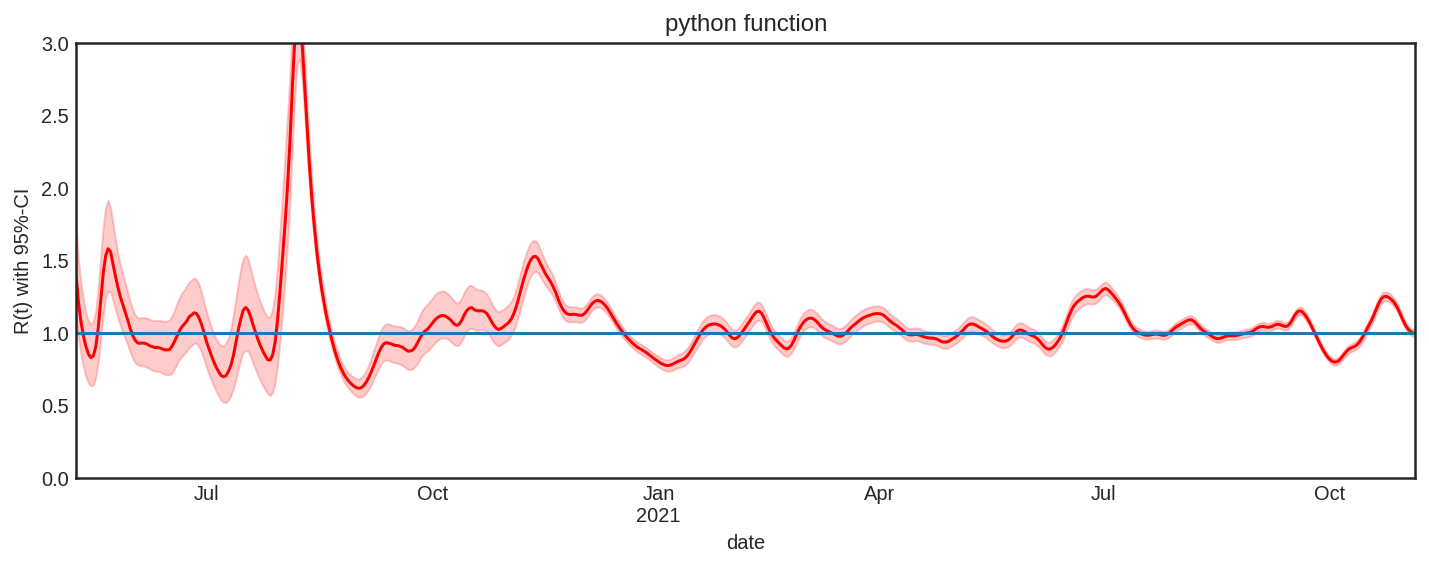

In [ ]:
# 파이썬 내장 함수
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
ax.fill_between(ch_time_varying_r.index, 
                    ch_time_varying_r['Q0.025'], 
                    ch_time_varying_r['Q0.975'], 
                    color='red', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('python function')
plt.show()

In [ ]:
df2=df.dropna()
df2

,date,case,W,Bett_g3
7,2020-05-08,12,4.060540e-07,1.004236
8,2020-05-09,18,1.522702e-06,1.006645
9,2020-05-10,34,5.075675e-06,1.000303
10,2020-05-11,35,1.522702e-05,0.997289
11,2020-05-12,27,4.152825e-05,0.999606
...,...,...,...,...
204,2020-11-21,386,0.000000e+00,0.998362
205,2020-11-22,330,0.000000e+00,0.997942
206,2020-11-23,271,0.000000e+00,1.002643
207,2020-11-24,349,0.000000e+00,1.000944


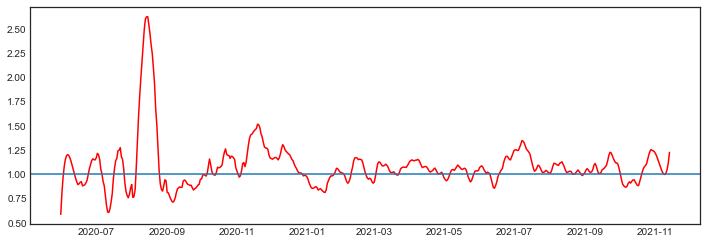

In [ ]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

#gaussian filter 예시
#x = np.linspace(0,2*np.pi,100)
#y = np.sin(x) + np.random.random(100) * 0.2
#yhat = savgol_filter(y, 51, 3)
#plt.plot(x, y)
#plt.plot(x,yhat, color='green')
#plt.show()

plt.figure(figsize=(12, 4))
x=list(df2.loc[30:,'date'])
y=df2.loc[30:,'Cori']
yhat=savgol_filter(y,31,4)
plt.plot(x,yhat,'r')
plt.axhline(y=1)
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)


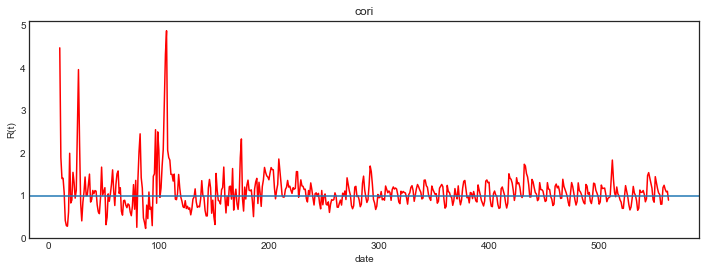

In [ ]:
from scipy.signal import savgol_filter

# cori
fig, ax = plt.subplots(1,1, figsize=(12, 4))
df.loc[10:,'Cori'].plot(ax=ax, color='red')

ax.set_xlabel('date')
ax.set_ylabel('R(t)')
#ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('cori')
plt.show()

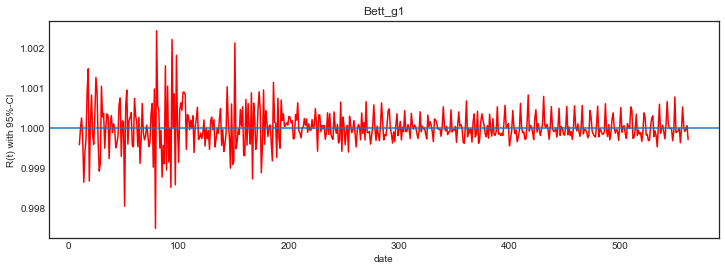

In [ ]:
# bett_g1
fig, ax = plt.subplots(1,1, figsize=(12, 4))

df.loc[10:,'Bett_g1'].plot(ax=ax, color='red')

ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
#ax.set_ylim([0,1.5])
ax.axhline(y=1)
ax.set_title('Bett_g1')
plt.show()

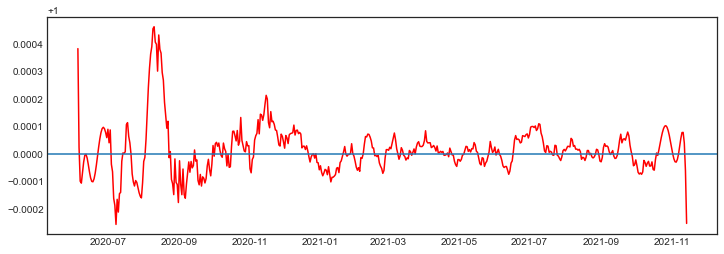

In [ ]:
# gaussian filter
plt.figure(figsize=(12, 4))
x=list(df2.loc[35:,'date'])
y=df2.loc[35:,'Bett_g1']
yhat=savgol_filter(y,51,9)
plt.plot(x,yhat,'r')
plt.axhline(y=1)
plt.show()

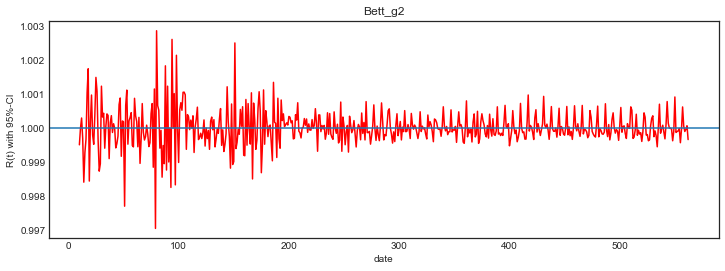

In [ ]:
# bett_g2
fig, ax = plt.subplots(1,1, figsize=(12, 4))

df.loc[10:,'Bett_g2'].plot(ax=ax, color='red')

ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
#ax.set_ylim([0,1.5])
ax.axhline(y=1)
ax.set_title('Bett_g2')
plt.show()

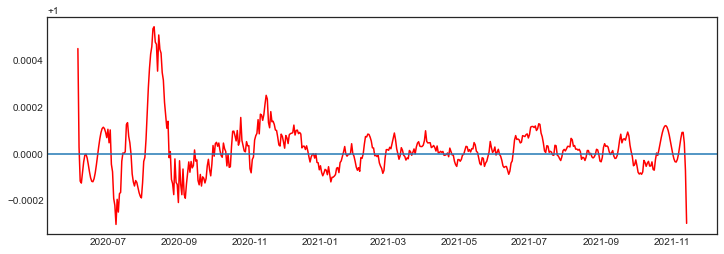

In [ ]:
# gaussian filter
plt.figure(figsize=(12, 4))
x=list(df2.loc[35:,'date'])
y=df2.loc[35:,'Bett_g2']
yhat=savgol_filter(y,51,9)
plt.plot(x,yhat,'r')
plt.axhline(y=1)
plt.show()

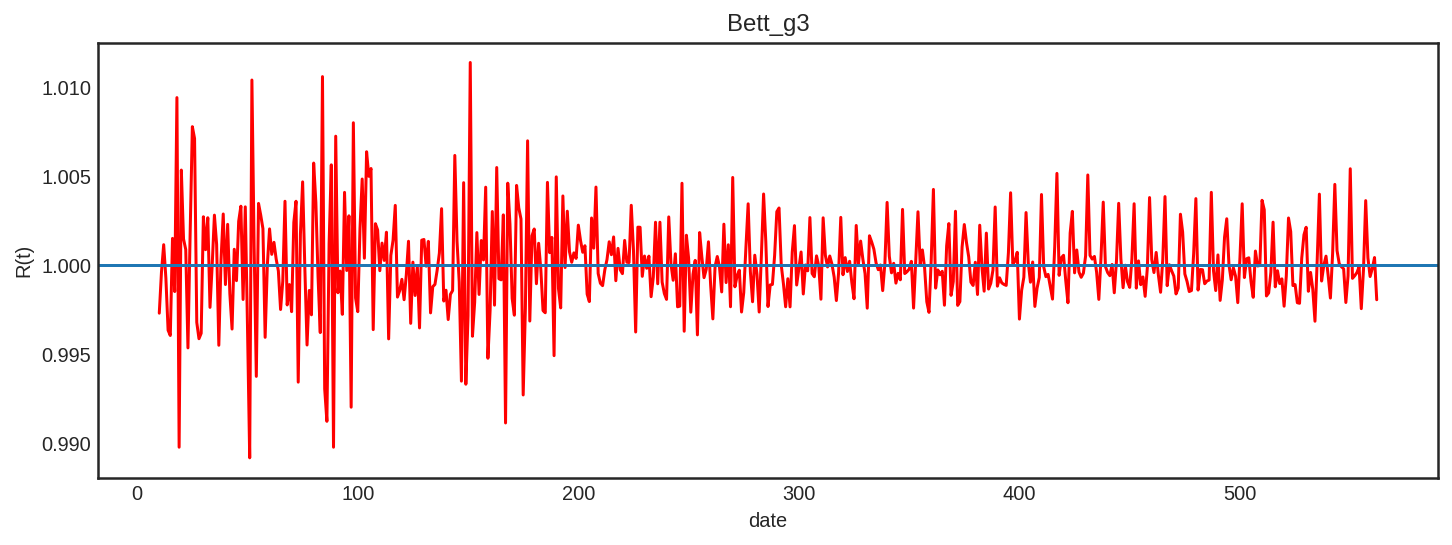

In [ ]:
# bett_g3
fig, ax = plt.subplots(1,1, figsize=(12, 4))

df.loc[10:,'Bett_g3'].plot(ax=ax, color='red')

ax.set_xlabel('date')
ax.set_ylabel('R(t)')
#ax.set_ylim([0,1.5])
ax.axhline(y=1)
ax.set_title('Bett_g3')
plt.show()

In [ ]:
from scipy.signal import savgol_filter

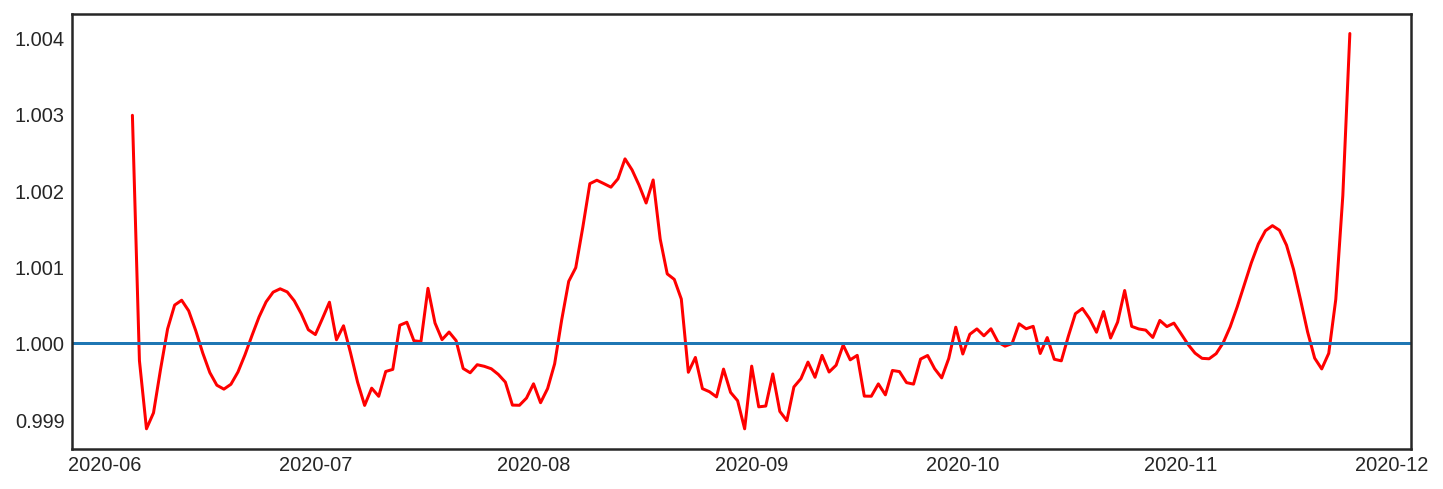

In [ ]:
# gaussian filter
plt.figure(figsize=(12, 4))
x=list(df2.loc[35:,'date'])
y=df2.loc[35:,'Bett_g3']
yhat=savgol_filter(y,51,9)
plt.plot(x,yhat,'r')
plt.axhline(y=1)
plt.show()